#  Assignment-3 


## Question-1(a)
### SIFT + SVM

In [1]:
import cv2
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
import os
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn import svm

(trainset, train_labels), (testset, test_labels) = cifar10.load_data()

trainset = np.array([np.mean(image, axis=2) for image in trainset])
testset = np.array([np.mean(image, axis=2) for image in testset])


def extract_sift_features(trainset):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in trainset:
        _, descriptor = sift.detectAndCompute(image.astype(np.uint8), None)
        image_descriptors.append(descriptor)

    return image_descriptors

def kmean_bow(all_descriptors, num_cluster):
    bow_dict = []

    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    return bow_dict

def create_feature_bow(image_descriptors, BoW, num_cluster):

    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)

            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)

    return X_features

from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn
import argparse
import os



image_desctiptors = extract_sift_features(trainset)

all_descriptors = []
for descriptor in image_desctiptors:
    if descriptor is not None:
        for des in descriptor:
            all_descriptors.append(des)

num_cluster = 10
BoW = kmean_bow(all_descriptors, num_cluster)

X_features = create_feature_bow(image_desctiptors, BoW, num_cluster)

X_train, X_test, Y_train, Y_test = train_test_split(X_features, train_labels, test_size = 0.2, random_state = 1)
model_svm = sklearn.svm.SVC(C = 30, random_state = 0)

model_svm.fit(X_train, Y_train)
filename = 'svm_model.sav'
pickle.dump(model_svm, open(filename, 'wb'))
print("score on training set params: ", model_svm.score(X_train, Y_train))
print("score on testing set params: ", model_svm.score(X_test, Y_test))

/Users/agastya/Documents/anaconda3/envs/eureka/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agastya/Documents/anaconda3/envs/eureka/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score on training set params:  0.392725
score on testing set params:  0.2048


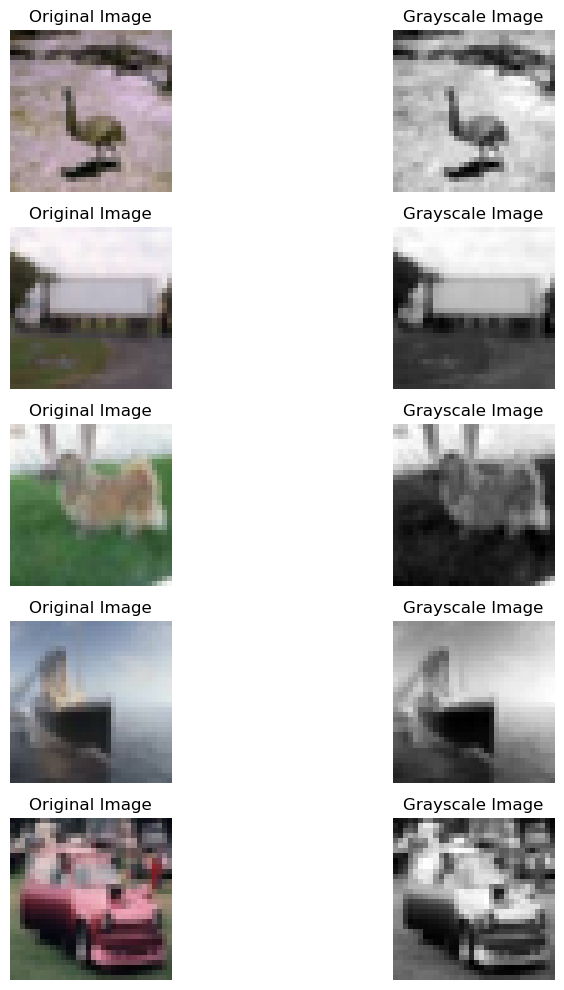

In [2]:
import matplotlib.pyplot as plt

# Function to plot CIFAR-10 images before and after grayscale conversion
def plot_images(trainset_color, trainset_gray, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
    idxs = np.random.choice(range(len(trainset_color)), num_images, replace=False)
    
    for i, idx in enumerate(idxs):
        # Original Image
        ax = axes[i, 0]
        ax.imshow(trainset_color[idx].astype('uint8'))
        ax.set_title("Original Image")
        ax.axis('off')
        
        # Grayscale Image
        ax = axes[i, 1]
        ax.imshow(trainset_gray[idx].astype('uint8'), cmap='gray')
        ax.set_title("Grayscale Image")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the original CIFAR-10 dataset to get color images
(trainset_color, _), (_, _) = cifar10.load_data()

# Call the function to plot images
plot_images(trainset_color, trainset)

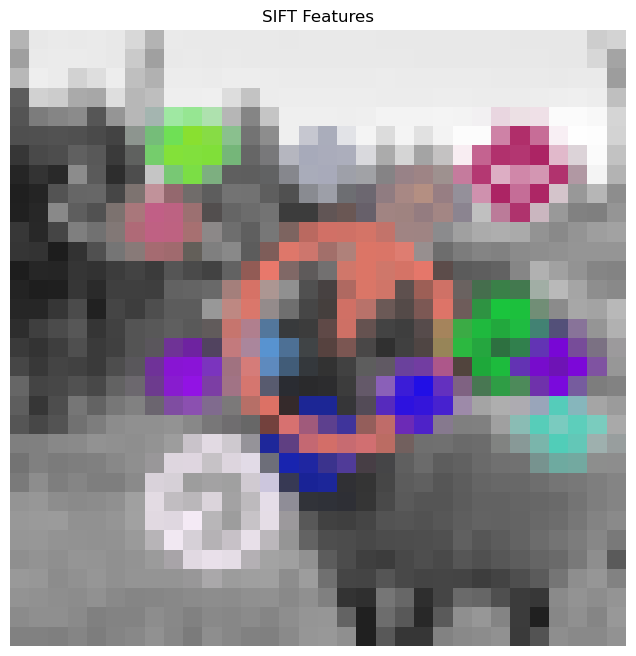

In [9]:
def plot_sift_features(gray_image, sift_keypoints):
    # Create a new figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # Draw the keypoints
    img_with_keypoints = cv2.drawKeypoints(gray_image, sift_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax.imshow(img_with_keypoints)
    ax.set_title("SIFT Features")
    ax.axis('off')
    plt.show()

# Select a random image from the grayscale dataset
random_idx = np.random.randint(0, len(trainset))
gray_image = trainset[random_idx].astype('uint8')

# Extract SIFT keypoints
sift = cv2.SIFT_create()
keypoints, _ = sift.detectAndCompute(gray_image, None)

# Plot the SIFT features
plot_sift_features(gray_image, keypoints)

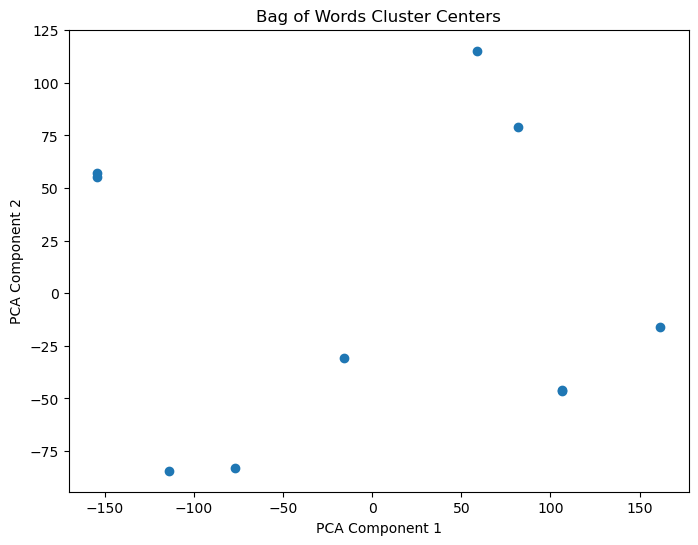

In [4]:
from sklearn.decomposition import PCA

def plot_bow_clusters(bow_dict):
    pca = PCA(n_components=2)
    bow_pca = pca.fit_transform(bow_dict)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(bow_pca[:, 0], bow_pca[:, 1], marker='o')
    plt.title('Bag of Words Cluster Centers')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Visualize the Bag of Words cluster centers
plot_bow_clusters(BoW)

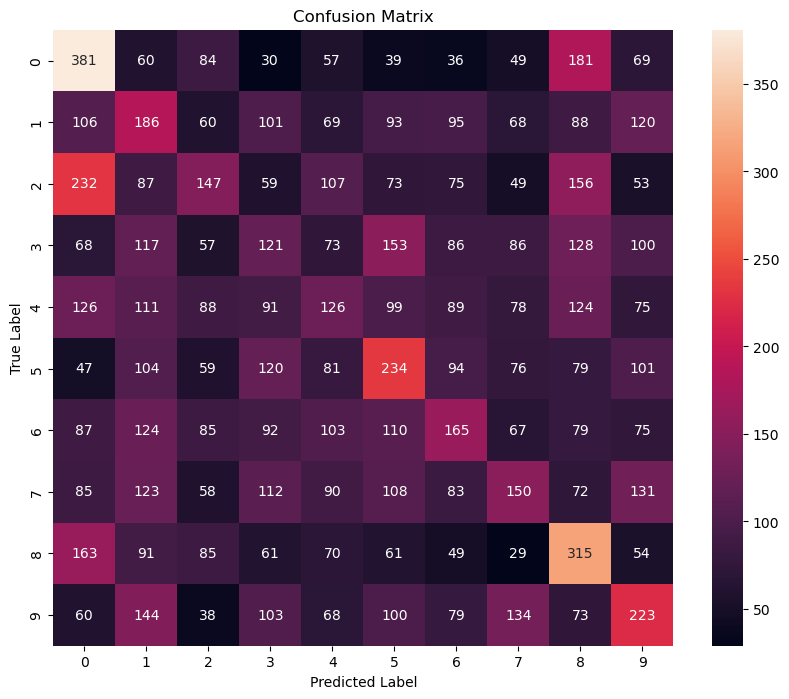

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions from the SVM model
Y_pred = model_svm.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Question-1(b)
### HOG + SVM

In [6]:
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert images to grayscale for HOG feature extraction
x_train_gray = np.array([np.mean(image, axis=2) for image in x_train])
x_test_gray = np.array([np.mean(image, axis=2) for image in x_test])

# Initialize lists to store HOG features
hog_features = []

# Extract HOG features from the images
for image in x_train_gray:
    # Extract HOG features
    features = hog(image, block_norm='L2-Hys', pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    hog_features.append(features)

# Stack the HOG features into a single numpy array
hog_features = np.vstack(hog_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, y_train, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM classifier
clf = svm.SVC()
clf.fit(X_train, y_train)

# Predict labels for the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/Users/agastya/Documents/anaconda3/envs/eureka/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 61.76%


## Question-2 (LBP Image)

## Applying HOG on LBP

In [2]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define a function to compute LBP for a grayscale image
def compute_lbp(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)
   
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            center = image[y, x]
            binary_pattern = 0
            binary_pattern |= (image[y - 1, x - 1] > center) << 7
            binary_pattern |= (image[y - 1, x] > center) << 6
            binary_pattern |= (image[y - 1, x + 1] > center) << 5
            binary_pattern |= (image[y, x + 1] > center) << 4
            binary_pattern |= (image[y + 1, x + 1] > center) << 3
            binary_pattern |= (image[y + 1, x] > center) << 2
            binary_pattern |= (image[y + 1, x - 1] > center) << 1
            binary_pattern |= (image[y, x - 1] > center) << 0
            lbp_image[y, x] = binary_pattern
   
    return lbp_image

# Initialize lists to store LBP images and labels
lbp_images = []
labels = []

# Compute LBP images and labels from the CIFAR-10 images
for image, label in zip(x_train, y_train):
    gray_image = np.mean(image, axis=2, dtype=np.uint8)  # Convert to grayscale
    lbp_image = compute_lbp(gray_image)
    lbp_images.append(lbp_image)
    labels.append(label)

# Convert the list of LBP images into a numpy array
lbp_images = np.array(lbp_images)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lbp_images, labels, test_size=0.2, random_state=42)

# Train an SVM classifier
clf = svm.SVC()
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict labels for the test data
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"LBP Accuracy: {accuracy * 100:.2f}%")

/Users/agastya/Documents/anaconda3/envs/eureka/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LBP Accuracy: 26.51%


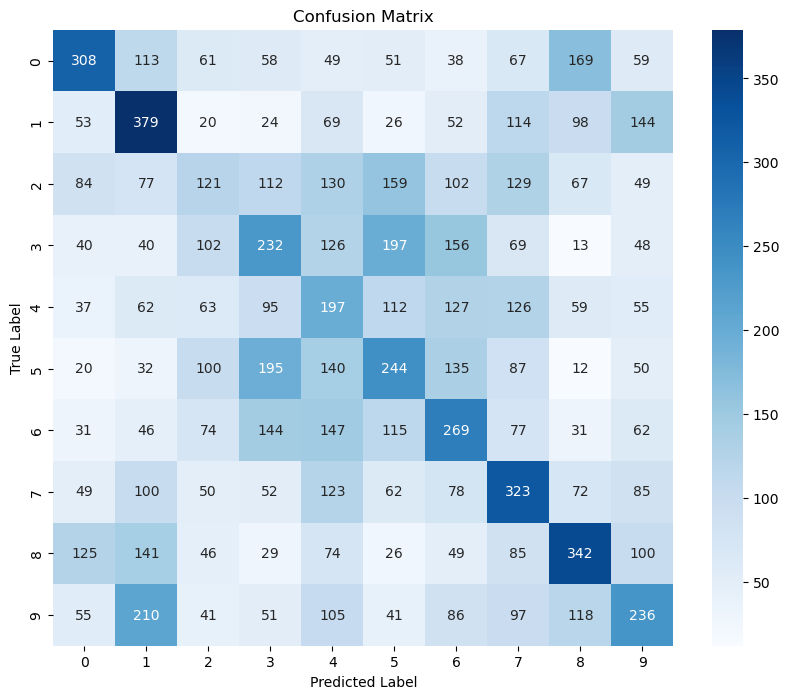

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Use seaborn to visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

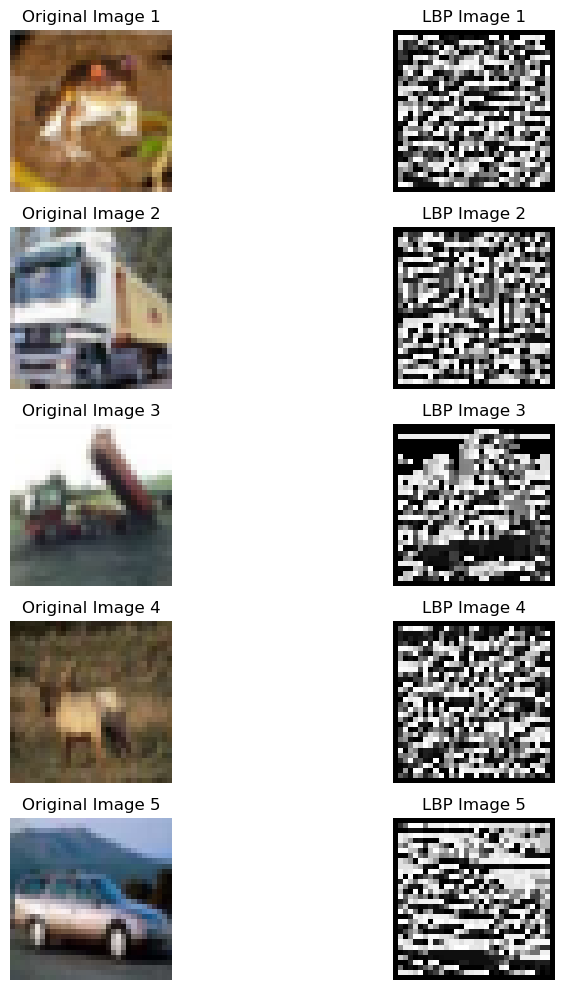

In [14]:
import matplotlib.pyplot as plt

# Function to plot original and LBP images side by side
def plot_original_and_lbp_images(original_images, lbp_images, num_pairs=5):
    fig, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, 2 * num_pairs))

    for i in range(num_pairs):
        # Plot original image
        ax = axes[i, 0]
        ax.imshow(original_images[i].astype('uint8'))
        ax.set_title(f"Original Image {i+1}")
        ax.axis('off')

        # Plot LBP image
        ax = axes[i, 1]
        ax.imshow(lbp_images[i], cmap='gray')
        ax.set_title(f"LBP Image {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Select a subset of original and LBP images to display
num_pairs_to_display = 5
original_images_subset = x_train[:num_pairs_to_display]
lbp_images_subset = lbp_images[:num_pairs_to_display]

# Call the function to plot the images
plot_original_and_lbp_images(original_images_subset, lbp_images_subset, num_pairs_to_display)

## Question-3 (Optical Flow)

##

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cap = cv2.VideoCapture("/Users/agastya/Desktop/video.mp4")
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

of_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
mask = np.zeros_like(old_frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    new_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **of_params)
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    
    img = cv2.add(frame, mask)
    cv2.imshow("frame", img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:  # Esc key to stop
        break
    
    old_gray = new_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv2.destroyAllWindows()
cap.release()